This notebook investigate several strategies to assess how to select hyperparameters for tikhonet.

In [61]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize']=[12,8]

In [62]:
matplotlib.rcParams['figure.figsize']=[12,8]

In [63]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [64]:
"""
Based on code written by alechat
"""

import os
import numpy as np
from subprocess import Popen, PIPE

def fits2npy(fits_file, idx_hdu):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//96
    data_list = []
    idx_list = range(0, 10000)
    for i in idx_list:
        y = (96*i)%(nb_gal_row*96)
        x = i//nb_gal_row * 96
        data_list.append(data[x:x+96,y:y+96])
    return np.asarray(data_list)

def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err

def generate_shape_txt(gal_file, psf_file, output_file, gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    print('Computing ellipticity for file: %s'%(gal_file))
    print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s | tee %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s | tee %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    cmd_file = 'get_shape.cmd'
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/fsureau/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr

def get_target_shape(gal_file, output_file, idx=4):
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    images = fits.getdata(gal_file, idx)
    psfs = fits.getdata(gal_file, 3)
    fits.writeto(tmp_file, images)
    fits.writeto(tmp_psf_file, psfs)
    stdout, stderr = generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    return stdout, stderr

def get_ellipticity(file_name):
    ellip = []
    with open(file_name, 'r') as f:
        data = f.readlines()
    for l in data:
        ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
    return np.asarray(ellip)

def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err


def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

In [65]:
from skimage import restoration
import copy
def dirac2d(ndim,shape,is_real=True):
    impr = np.zeros([3] * ndim)
    impr[(slice(1, 2), ) * ndim] = 1.0 
    return restoration.uft.ir2tf(impr, shape, is_real=is_real), impr

def correct_pixel_window_function(fpsf, size_img):
    """
    Correct for pixel window effect (beware of aliasing)
    This is useful for convolution with band limited signal sampled higher than Nyquist frequency,
    to better approximate continuous convolution followed by sampling with discrete convolution.
    @param fpsf fourier transform to be corrected for sampling effect
    @param size_img size of input image (to check if real or complex transform)
    @return the fourier transform with extra phase (same size as fpsf)
    """
    mult_x=np.array(np.fft.fftfreq(size_img[0]),dtype=np.float64)
    if fpsf.shape[1] != size_img[1]:
        mult_y=np.array(np.fft.rfftfreq(size_img[1]),dtype=np.float64)
    else:
        mult_y=np.array(np.fft.fftfreq(size_img[1]),dtype=np.float64)
    pwf_x=np.array([np.sinc(kx) for kx in mult_x],dtype=np.float64)
    pwf_y=np.array([np.sinc(ky) for ky in mult_y],dtype=np.float64)
    return copy.deepcopy(fpsf / np.outer(pwf_x, pwf_y))

def perform_shift_in_frequency(fpsf, size_img, shift):
    """
    Add phase to fourier transform to shift signal centered in *shift* to 0
    @param fpsf fourier transform needing extra phase factor
    @param size_img size of input image (to check if real or complex transform)
    @param shift, shift in [x,y] for array[x,y]
    @return the fourier transform with extra phase (same size as fpsf)
    """
    phase_factor= np.float64(2. * np.pi) * shift.astype(np.float64)
    if phase_factor[0] ==0.:
        kx_ft=np.zeros(size_img[0])+1.
    else :
        kx_ft=np.exp(np.fft.fftfreq(size_img[0],d=1./phase_factor[0])*1j)
    if phase_factor[1] ==0.:
        ky_ft=np.zeros(fpsf.shape[1],dtype=np.float64)+1.
    else:
        if fpsf.shape[1] != size_img[1]:
            ky_ft=np.exp(np.fft.rfftfreq(size_img[1],d=1./phase_factor[1])*1j)
        else:
            ky_ft=np.exp(np.fft.fftfreq(size_img[1],d=1./phase_factor[1])*1j)
    return copy.deepcopy(np.outer(kx_ft,ky_ft)*fpsf)

def recenter_psf(psf,param):
    fpsf=np.fft.fft2(psf)
    fpsf_ctr=perform_shift_in_frequency(fpsf, psf.shape, param)
    return np.real(np.fft.ifft2(fpsf_ctr))
    

In [66]:
%load_ext line_profiler
%load_ext Cython
import line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [113]:
#Set compiler directives (cf. http://docs.cython.org/src/reference/compilation.html)
from Cython.Compiler.Options import get_directive_defaults
directive_defaults = get_directive_defaults()
directive_defaults['profile'] = True
directive_defaults['linetrace'] = True
directive_defaults['binding'] = True

### Cython versions

In [284]:
%%cython -f --compile-args=-DCYTHON_TRACE=1 --compile-args=-fopenmp --link-args=-fopenmp
#-a --compile-args=-fopenmp --link-args=-fopenmp


# cython: profile=True, linetrace=True, binding=True
#--annotate
import cython
from cython.parallel import prange
cimport numpy as cnp
import numpy as np
from libc.math cimport pow

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
@cython.cdivision(True)
cpdef cy_sure_proj_risk_est_1d(double tau, double[::1] psf_ps,double[::1] y_ps,  double[::1] reg_ps,
                               Py_ssize_t Ndata, double sigma2):
   
    cdef Py_ssize_t kx
    cdef double den=0.
    cdef double risk=0. 

    
    for kx in range(Ndata):
        den=psf_ps[kx]+tau*reg_ps[kx]
        risk+=psf_ps[kx]*y_ps[kx]/pow(den,2.0)+2.0*(sigma2-y_ps[kx])/den
    return risk

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
@cython.cdivision(True)
cpdef cy_sure_pred_risk_est_1d(double tau, double[::1] psf_ps, double[::1] y_ps, double[::1] reg_ps,
                               Py_ssize_t Ndata, double sigma2):
   
    cdef Py_ssize_t kx
    cdef double wiener=0., wiener2=0.
    cdef double risk=0. 
    
    for kx in range(Ndata):
        wiener=psf_ps[kx]/(psf_ps[kx]+tau*reg_ps[kx])
        wiener2=pow(wiener,2.0)
        risk+=wiener2*y_ps[kx]+2*(sigma2-y_ps[kx])*wiener

    return risk

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
@cython.cdivision(True)
cpdef cy_gcv_risk_est_1d(double tau,double[::1] psf_ps, double[::1] y_ps, double[::1] reg_ps,
                               Py_ssize_t Ndata, double sigma2):
   
    cdef Py_ssize_t kx
    cdef double wiener=0., wiener2=0.
    cdef double den=0., num=0.
    cdef double risk=0. 
    
    for kx in range(Ndata):
        wiener=psf_ps[kx]/(psf_ps[kx]+tau*reg_ps[kx])
        num+=y_ps[kx]*pow(1.0-wiener,2.0)
        den+=(1.0-wiener)
    return num/pow(den,2.0)

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
@cython.cdivision(True)
cpdef cy_pereyra_hyper(double tau0, double alpha, double beta, double[::1] psf_ps, 
                               double[::1] y_ps, double[::1] reg_ps,
                               Py_ssize_t Ndata,Py_ssize_t Nit, double sigma2):
   
    cdef Py_ssize_t kx,kit
    cdef double deconvf2=0.
    cdef double hyp_cur=tau0*sigma2
    for kit in range(Nit):
        deconvf2=0
        for kx in range(Ndata):
            deconvf2+=psf_ps[kx]*reg_ps[kx]*y_ps[kx]/pow(psf_ps[kx]+hyp_cur*reg_ps[kx],2.0)
        hyp_cur=(Ndata/2.0 + alpha - 1.0)/(deconvf2+beta)*sigma2
    return hyp_cur

### Python Versions

In [262]:
def proj_sure(h2,y2,x,reg2,sigma2):
    den=h2+x*reg2
    den2=den**2
    return np.sum(h2*y2/den2+2.0*(sigma2-y2)/den)

def pred_risk_est(h2,y2,x,reg2,sigma2):
    wiener_f=h2/(h2+x*reg2)
    wiener_f2=wiener_f**2
    t1=np.sum(wiener_f2 * y2)
    t2=2.0*(sigma2) * np.sum(wiener_f)
    t3=-2* np.sum(wiener_f*y2)
    return t1+t2+t3

def gcv(h2,y2,x,reg2):
    wiener_f=h2/(h2+x*reg2)
    res=np.sum(y2*(1.0-wiener_f)**2)
    tr=np.sum(1.0-wiener_f)**2
    return res/tr

In [445]:
import scipy.optimize
def pred_sure_list(h2,y2,xlist,reg2,sigma2):
    return [pred_risk_est(h2,y2,x,reg2,sigma2) for x in xlist]

def proj_sure_list(h2,y2,xlist,reg2,sigma2):
    return [proj_sure(h2,y2,x,reg2,sigma2) for x in xlist]

def gcv_list(h2,y2,xlist,reg2):
    return [gcv(h2,y2,x,reg2) for x in xlist]

def lambda_pereyra_fourier(h2,y2,x,sigma2,reg2,nit=10,alpha=1,beta=1):
    tau_list=[x]
    tau_cur=x
    n_im=np.size(y2)
    num_f=h2*reg2*y2
    for kit in range(nit):
        deconvf2=num_f/(h2+tau_cur*sigma2*reg2)**2
        tau_cur=(n_im/2.0 + alpha - 1.0)/(np.sum(deconvf2)+beta)
        tau_list.append(tau_cur)
    return np.array(tau_list)*sigma2

def min_risk_est_1d(h2,y2,reg2,sigma2,method,risktype="SureProj",tau0=1.0):
    
    bounds=scipy.optimize.Bounds(1e-4,np.inf,keep_feasible=True)
    
    if(risktype is "SureProj"):
        if method is "Powell":
            return scipy.optimize.minimize(cy_sure_proj_risk_est_1d, tau0, args=(h2,y2,reg2, y2.size,sigma2), method='Powell',
                             bounds=bounds,options={'xtol': 1e-4, 'maxiter': 100, 'disp': False})
        elif method is "Brent" or "golden":
            return scipy.optimize.minimize_scalar(cy_sure_proj_risk_est_1d, args=(h2,y2,reg2, y2.size,sigma2), method=method,
                             bounds=bounds,options={'xtol': 1e-4, 'maxiter': 100})
        else:
            raise ValueError("Optim. Method {0} is not supported".format(method))

    elif(risktype is "SurePred"):
        if method is "Powell":
            return scipy.optimize.minimize(cy_sure_pred_risk_est_1d, tau0, args=(h2,y2,reg2, y2.size,sigma2), method='Powell',
                             bounds=bounds,options={'xtol': 1e-4, 'maxiter': 100, 'disp': False})
        elif method is "Brent" or "golden":
            return scipy.optimize.minimize_scalar(cy_sure_pred_risk_est_1d, args=(h2,y2,reg2, y2.size,sigma2), method=method,
                             bounds=bounds,options={'xtol': 1e-4, 'maxiter': 100})
        else:
            raise ValueError("Optim. Method {0} is not supported".format(method))

    elif(risktype is "GCV"):
        if method is "Powell":
            return scipy.optimize.minimize(cy_gcv_risk_est_1d, tau0, args=(h2,y2,reg2, y2.size,sigma2), method='Powell',
                             bounds=bounds,options={'xtol': 1e-4, 'maxiter': 100, 'disp': False})
        elif method is "Brent" or "golden":
            return scipy.optimize.minimize_scalar(cy_gcv_risk_est_1d, args=(h2,y2,reg2, y2.size,sigma2), method=method,
                             bounds=bounds,options={'xtol': 1e-4, 'maxiter': 100})
        else:
            raise ValueError("Optim. Method {0} is not supported".format(method))
    else:
        raise ValueError("Risk {0} is not supported".format(risktype))
        
        

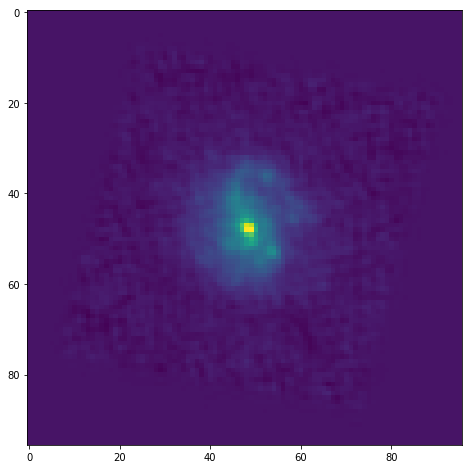

In [434]:
from skimage import restoration
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
testset_file = 'image-shfl-0-multihdu.fits'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
data_path='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
#ref=(slice(96,192),slice(96,192)) #for centering
ref=(slice(96,192),slice(0,96)) #for spiral
image=fits.getdata(data_path+testset_file,0)[ref]
psf=fits.getdata(data_path+testset_file,1)[ref]
target=fits.getdata(data_path+testset_file,2)[ref]
psf_ctr=recenter_psf(psf,np.array([-0.5,-0.5]))
psf_tar=fits.getdata('/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits')
plt.imshow(image)

In [435]:
import scipy.signal
from DeepDeconv.utils.deconv_utils import FISTA,tikhonov
from DeepDeconv.utils.data_utils import add_noise
np.random.seed(0)
SNR_SIMU=1000
noisy_im,SNR_list,sigma_list=add_noise(image,SNR=SNR_SIMU)
yf=restoration.uft.ufft2(noisy_im)
trans_func = restoration.uft.ir2tf(psf_ctr, image.shape, is_real=False)
deconv_im0=np.real(restoration.wiener(noisy_im,trans_func,1/SNR_list[0], is_real=False,clip=False))
tfdirac,imdirac=dirac2d(noisy_im.ndim,noisy_im.shape,is_real=False)
lap_tf, lap_ker = restoration.uft.laplacian(image.ndim, image.shape, is_real=False)
fullh=np.abs(trans_func)
lst_nonz=np.where(fullh>0)


Laplacian


In [436]:
trans_func_ps=np.abs(trans_func)**2
reg_dirac_ps=np.abs(tfdirac)**2
reg_lap_ps=np.abs(lap_tf)**2
im_ps=np.abs(noisy_im)**2
sigma2=sigma_list[0]**2

h2=np.abs(trans_func)**2 #This is |h_w|^2
l2=np.abs(lap_tf)**2 #This is |l_w|^2 in case of laplacian
d2=np.abs(tfdirac)**2 #This is 1 (tikhonov:Dirac kernel)
y2=np.abs(restoration.uft.ufft2(noisy_im))**2 #This is the FFT of noisy image

lst_nonz=np.where(trans_func_ps>1e-8)
h2_nonz=np.abs(trans_func[lst_nonz])**2 #This is |h_w|^2
l2_nonz=np.abs(lap_tf[lst_nonz])**2 #This is |l_w|^2 in case of laplacian
d2_nonz=np.abs(tfdirac[lst_nonz])**2 #This is 1 (tikhonov:Dirac kernel)
y2_nonz=np.abs(restoration.uft.ufft2(noisy_im)[lst_nonz])**2 #This is the FFT of noisy image




In [437]:
# profile = line_profiler.LineProfiler(cy_sure_proj_risk_est_1d)
# profile.runcall(min_sure_proj_risk_est_1d, y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2,"Brent")
# profile.print_stats()
# %lprun -f cy_sure_proj_risk_est_1d cy_sure_proj_risk_est_1d(y2_nonz,h2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2)

### Test speed of multidim vs scale minimization.

In [438]:
tic = timeit.default_timer()
print(scipy.optimize.minimize(cy_sure_proj_risk_est_1d, 1.0, args=(h2_nonz,y2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='Powell',
                             bounds=(0,None),options={'xtol': 0.001, 'maxiter': 100, 'disp': True}))
toc = timeit.default_timer()
print("CYTHON MIN=",toc-tic)
tic = timeit.default_timer()
print(scipy.optimize.minimize_scalar(cy_sure_proj_risk_est_1d, args=(h2_nonz,y2_nonz,d2_nonz, y2_nonz.size,sigma_list[0]**2), method='brent',
                             bounds=(0,None),options={'xtol': 0.001, 'maxiter': 100}))
toc = timeit.default_timer()
print("CYTHON2 MIN=",toc-tic)



Optimization terminated successfully.
         Current function value: -10.777978
         Iterations: 5
         Function evaluations: 91
   direc: array([[1.]])
     fun: array(-10.77797793)
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 5
  status: 0
 success: True
       x: array(0.00147857)
CYTHON MIN= 0.009287958033382893
     fun: -10.777978031994426
    nfev: 25
     nit: 21
 success: True
       x: 0.0014799029962370754
CYTHON2 MIN= 0.001506648026406765


### Test speed and results for different risk minimization

In [439]:
def manual_deconv_l2(noisy_im,trans_func,trans_reg,hyp_param):
    hfstar=np.conj(trans_func)
    h2=np.abs(trans_func)**2
    d2=np.abs(trans_reg)**2
    filter_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
    yf=restoration.uft.ufft2(noisy_im)
    sol=np.real(restoration.uft.uifft2(filter_f*yf))
    return sol

 

In [440]:
import timeit
check_hyper=10**np.arange(-5.0,2.5,0.001)
sigma2=sigma_list[0]**2

for reg in ["TIKHO","WIENER"]:
    if reg is "TIKHO":
        reg2=d2
        reg2_nonz=d2_nonz
        print("TIKHO SNR {0}:".format(SNR_SIMU))
    else:
        reg2=l2
        reg2_nonz=l2_nonz
        print("WIENER SNR {0}:".format(SNR_SIMU))
        
    print("\t TEST SURE PROJ")
    tic = timeit.default_timer()
    py_sure_proj_risk=proj_sure_list(h2_nonz,y2_nonz,check_hyper,reg2_nonz,sigma2)
    py_sure_proj_min_risk=check_hyper[np.argmin(py_sure_proj_risk)]
    toc = timeit.default_timer()
    print("\t\t PYTHON=",toc-tic,np.min(py_sure_proj_risk),py_sure_proj_min_risk)
    tic = timeit.default_timer()
    cy_sure_proj_risk= min_risk_est_1d(h2_nonz,y2_nonz,reg2_nonz,sigma2,"Brent",risktype="SureProj",tau0=1.0)
    toc = timeit.default_timer()
    print("\t\t CYTHON=",toc-tic,cy_sure_proj_risk.fun,cy_sure_proj_risk.x)

    print("\t TEST SURE PRED")
    tic = timeit.default_timer()
    py_sure_pred_risk=pred_sure_list(h2,y2,check_hyper,reg2,sigma2)
    py_sure_pred_min_risk=check_hyper[np.argmin(py_sure_pred_risk)]
    toc = timeit.default_timer()
    print("\t\t PYTHON=",toc-tic,np.min(py_sure_pred_risk),py_sure_pred_min_risk)
    tic = timeit.default_timer()
    cy_sure_pred_risk= min_risk_est_1d(h2.flatten(),y2.flatten(),reg2.flatten(),sigma2,"Brent",risktype="SurePred",tau0=1.0)
    toc = timeit.default_timer()
    print("\t\t CYTHON=",toc-tic,cy_sure_pred_risk.fun,cy_sure_pred_risk.x)

    print("\t TEST GCV")
    tic = timeit.default_timer()
    py_gcv_risk=gcv_list(h2,y2,check_hyper,reg2)
    py_gcv_min_risk=check_hyper[np.argmin(py_gcv_risk)]
    toc = timeit.default_timer()
    print("\t\t PYTHON=",toc-tic,np.min(py_gcv_risk),py_gcv_min_risk)
    tic = timeit.default_timer()
    cy_gcv_risk= min_risk_est_1d(h2.flatten(),y2.flatten(),reg2.flatten(),sigma2,"Brent",risktype="GCV",tau0=1.0)
    toc = timeit.default_timer()
    print("\t\t CYTHON=",toc-tic,cy_gcv_risk.fun,cy_gcv_risk.x)

    print("\t TEST Pereyra")
    tau0=1.0
    alpha_per=1.0
    beta_per=1.0
    nit_per=100
    tic = timeit.default_timer()
    py_per_risk=lambda_pereyra_fourier(h2,y2,tau0,sigma2,reg2,nit=nit_per,alpha=alpha_per,beta=beta_per)
    py_per_min_risk=py_per_risk[-1]
    toc = timeit.default_timer()
    print("\t\t PYTHON=",toc-tic,py_per_min_risk)
    tic = timeit.default_timer()
    cy_per_risk= cy_pereyra_hyper(tau0,alpha_per,beta_per,h2.flatten(),y2.flatten(),reg2.flatten(),h2.size,nit_per,sigma2)
    toc = timeit.default_timer()
    print("\t\t CYTHON=",toc-tic,cy_per_risk,"\n")
    
    if reg is "TIKHO":
        deconv_sure_proj_tikho=manual_deconv_l2(noisy_im,trans_func,tfdirac,cy_sure_proj_risk.x)
        deconv_sure_pred_tikho=manual_deconv_l2(noisy_im,trans_func,tfdirac,cy_sure_pred_risk.x)
        deconv_tikho_gcv=manual_deconv_l2(noisy_im,trans_func,tfdirac,cy_gcv_risk.x)
        deconv_tikho_per=manual_deconv_l2(noisy_im,trans_func,tfdirac,cy_per_risk)
    else:
        deconv_sure_proj_wiener=manual_deconv_l2(noisy_im,trans_func,lap_tf,cy_sure_proj_risk.x)
        deconv_sure_pred_wiener=manual_deconv_l2(noisy_im,trans_func,lap_tf,cy_sure_pred_risk.x)
        deconv_wiener_gcv=manual_deconv_l2(noisy_im,trans_func,lap_tf,cy_gcv_risk.x)
        deconv_wiener_per=manual_deconv_l2(noisy_im,trans_func,lap_tf,cy_per_risk)




TIKHO SNR 1000:
	 TEST SURE PROJ
		 PYTHON= 0.6483417088165879 -10.777978076722507 0.0014791083881706755
		 CYTHON= 0.0014067478477954865 -10.777978095581187 0.0014794472993206098
	 TEST SURE PRED
		 PYTHON= 1.4184552738443017 -4.117302247335232 0.0024547089156895414
		 CYTHON= 0.002738378942012787 -4.117302248029835 0.0024564598387320294
	 TEST GCV
		 PYTHON= 1.3873953707516193 8.177611717928745e-10 0.002437810818373227
		 CYTHON= 0.0022709928452968597 8.177611655678411e-10 0.0024387218094157445
	 TEST Pereyra
		 PYTHON= 0.013039573095738888 0.0015343027654104795
		 CYTHON= 0.0043977489694952965 0.0015343027654104759 

WIENER SNR 1000:
	 TEST SURE PROJ
		 PYTHON= 0.6701111681759357 -10.63985974298706 8.016780633882364e-05
		 CYTHON= 0.0016797389835119247 -10.63986004684533 8.023950959543858e-05
	 TEST SURE PRED
		 PYTHON= 1.413931267336011 -4.116754480511776 0.00017619760464133175
		 CYTHON= 0.0027490947395563126 -4.116754481162996 0.00017604851328202983
	 TEST GCV
		 PYTHON= 1.382766

Results Obtained through prototype

Tikho SNR : 20.0 
 SURE PROJ= 5.0118723362713204 
 SURE PRED= 0.758577575029002 
 GCV= 0.6456542290345031 
 PEREYRA GAMMA= 47.408643953151675 


Wiener SNR: 20.0 
 SURE PROJ= 97.72372209554754 
 SURE PRED= 97.72372209554754 
 GCV= 97.72372209554754 
 PEREYRA GAMMA= 46.96075963415518 


In [441]:
hyp_param=1.0/(SNR_list[0]) #Choice of Alexis (incorrect)
skimage_tikho=restoration.wiener(noisy_im,trans_func,hyp_param,reg=tfdirac, is_real=False,clip=False)
skimage_wiener=restoration.wiener(noisy_im,trans_func,hyp_param,reg=lap_tf, is_real=False,clip=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f95cd376be0>,
 Text(0.5, 1.0, 'Pereyra Wiener'))

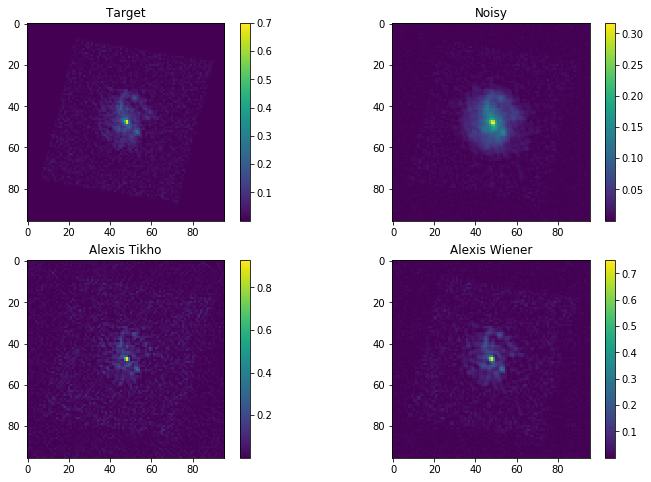

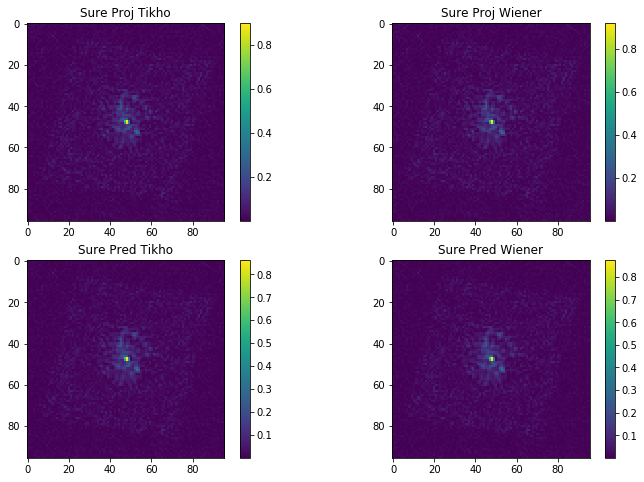

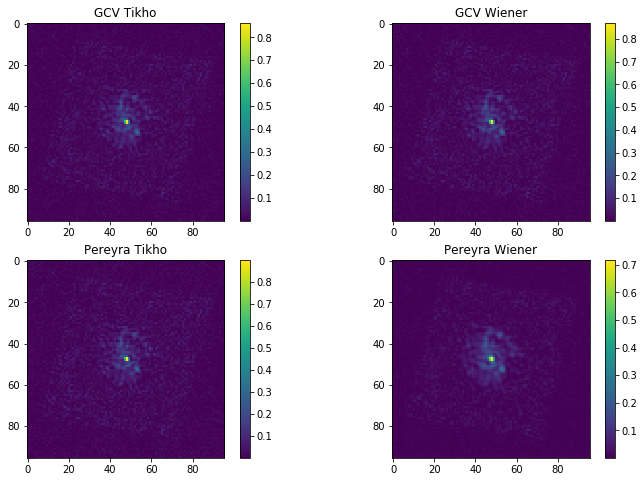

In [442]:
plt.figure()
plt.subplot(221),plt.imshow(np.abs(target)),plt.colorbar(),plt.title('Target')
plt.subplot(222),plt.imshow(np.abs(noisy_im)),plt.colorbar(),plt.title('Noisy')
plt.subplot(223),plt.imshow(np.abs(skimage_tikho)),plt.colorbar(),plt.title('Alexis Tikho')
plt.subplot(224),plt.imshow(np.abs(skimage_wiener)),plt.colorbar(),plt.title('Alexis Wiener')
plt.figure()
plt.subplot(221),plt.imshow(np.abs(deconv_sure_proj_tikho)),plt.colorbar(),plt.title('Sure Proj Tikho')
plt.subplot(222),plt.imshow(np.abs(deconv_sure_proj_wiener)),plt.colorbar(),plt.title('Sure Proj Wiener')
plt.subplot(223),plt.imshow(np.abs(deconv_sure_pred_tikho)),plt.colorbar(),plt.title('Sure Pred Tikho')
plt.subplot(224),plt.imshow(np.abs(deconv_sure_pred_wiener)),plt.colorbar(),plt.title('Sure Pred Wiener')
plt.figure()
plt.subplot(221),plt.imshow(np.abs(deconv_tikho_gcv)),plt.colorbar(),plt.title('GCV Tikho')
plt.subplot(222),plt.imshow(np.abs(deconv_wiener_gcv)),plt.colorbar(),plt.title('GCV Wiener')
plt.subplot(223),plt.imshow(np.abs(deconv_tikho_per)),plt.colorbar(),plt.title('Pereyra Tikho')
plt.subplot(224),plt.imshow(np.abs(deconv_wiener_per)),plt.colorbar(),plt.title('Pereyra Wiener')





(<matplotlib.axes._subplots.AxesSubplot at 0x7f95cbe52898>,
 Text(0.5, 1.0, 'Pereyra Wiener'))

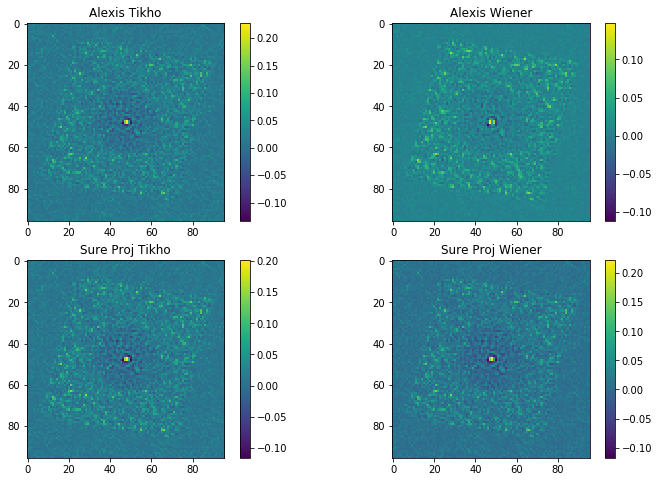

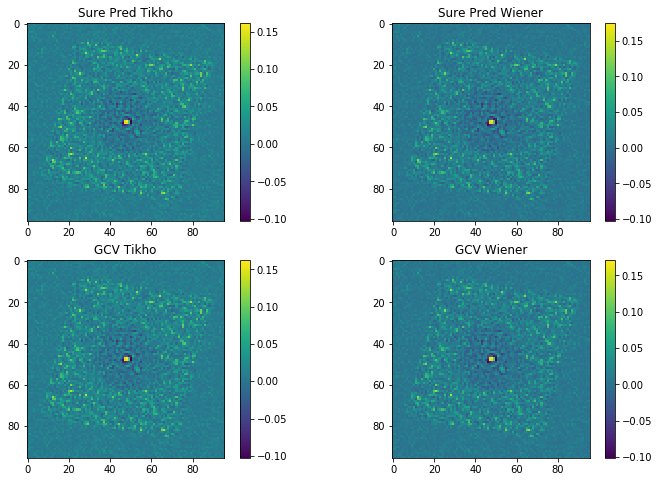

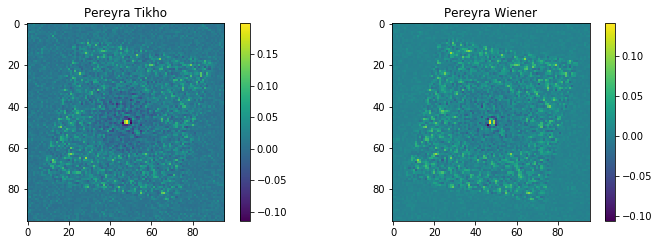

In [443]:
plt.figure()
plt.subplot(221),plt.imshow(np.abs(skimage_tikho)-target),plt.colorbar(),plt.title('Alexis Tikho')
plt.subplot(222),plt.imshow(np.abs(skimage_wiener)-target),plt.colorbar(),plt.title('Alexis Wiener')
plt.subplot(223),plt.imshow(np.abs(deconv_sure_proj_tikho)-target),plt.colorbar(),plt.title('Sure Proj Tikho')
plt.subplot(224),plt.imshow(np.abs(deconv_sure_proj_wiener)-target),plt.colorbar(),plt.title('Sure Proj Wiener')
plt.figure()
plt.subplot(221),plt.imshow(np.abs(deconv_sure_pred_tikho)-target),plt.colorbar(),plt.title('Sure Pred Tikho')
plt.subplot(222),plt.imshow(np.abs(deconv_sure_pred_wiener)-target),plt.colorbar(),plt.title('Sure Pred Wiener')
plt.subplot(223),plt.imshow(np.abs(deconv_tikho_gcv)-target),plt.colorbar(),plt.title('GCV Tikho')
plt.subplot(224),plt.imshow(np.abs(deconv_wiener_gcv)-target),plt.colorbar(),plt.title('GCV Wiener')
plt.figure()
plt.subplot(221),plt.imshow(np.abs(deconv_tikho_per)-target),plt.colorbar(),plt.title('Pereyra Tikho')
plt.subplot(222),plt.imshow(np.abs(deconv_wiener_per)-target),plt.colorbar(),plt.title('Pereyra Wiener')




